# More insights from Facebook Page's data that Facebook Page Insight doesn't tell you

Facebook Page Insights is the first stop tool for all of Facebook page admin to analyze and measure the performance of the content posted / published on the page. The tool itself provides lot of useful metrics out of the book which is quite necessary for the Page admin to do analysis. However, one of the feature that seems to be not talked about much over the internet base on my search is about how to make use of the raw data behind those metrics that can be exported.

As I'm currently running my online comics page with 55k Page Like for many years (https://facebook.com/manudglom), I have confusion many times on which metrics should I really move it's needle to increase the total page's like. Is it a set of 'Like, Comment, Share'? or Is it actually just 'Share'? With the average performance of my content, how can I predict the growth of the page?

With these curious in mind, it drives me to extract the data and do some analysis to answer my top 3 important questions as listed below.

1. What are the factors that influence new daily page like?
2. Given there is a new post published on my page, what are the expected value of factors that influences the page like?
3. How can we predict daily page like when there is a new post published?

### Step 1 Gather - Extract data from Facebook Page Insight. 

There are 2 type of the data which is Page level and Post level. Unfortunately, the oldest for Page level data that is allowed to extract is 180 from today date. So, I extract all of them to have the most data point as I can. While on the post level, it has 180 days period limitation per one extraction. So, I tried to extract for about 2 years for this attempt. 

The reason for 2 years (2018-2019) data is that Facebook newsfeed has major algorithm change on January 2018 (https://blog.hootsuite.com/facebook-algorithm/). So, I avoid the data older than that to influence the result in wrong way.

### Step 2 Assess - Load and Explore data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import datetime

# Set configuration to display all columns in Jupyter Notebook
pd.set_option('display.max_columns', None)

# Read the exported data which is in CSV data
df1 = pd.read_csv('2019-1.csv')
# Drop the first row as it is the column's description
df1.drop(axis=1,index=0,inplace=True)

df2 = pd.read_csv('2019-2.csv')
df2.drop(axis=1,index=0,inplace=True)

df3 = pd.read_csv('2019-3.csv')
df3.drop(axis=1,index=0,inplace=True)

df4 = pd.read_csv('2018-1.csv')
df4.drop(axis=1,index=0,inplace=True)

df5 = pd.read_csv('2018-2.csv')
df5.drop(axis=1,index=0,inplace=True)

df6 = pd.read_csv('2018-3.csv')
df6.drop(axis=1,index=0,inplace=True)

After I check the data format from info(), I found that all of them has the same columns. So, I append them to be one dataframe and explore the data type and null value further.

In [4]:
# View initial data after append
df=df1.append([df2, df3, df4, df5, df6])
df.head()

,Audience Targeting,Countries,Languages,Lifetime Average time video viewed,Lifetime Engaged Users,Lifetime Matched Audience Targeting Consumers on Post,Lifetime Matched Audience Targeting Consumptions by Type - link clicks,Lifetime Matched Audience Targeting Consumptions by Type - other clicks,Lifetime Matched Audience Targeting Consumptions by Type - photo view,Lifetime Matched Audience Targeting Consumptions by Type - video play,Lifetime Matched Audience Targeting Consumptions on Post,Lifetime Negative Feedback,Lifetime Negative Feedback by Type - hide_all_clicks,Lifetime Negative Feedback by Type - hide_clicks,Lifetime Negative Feedback by Type - unlike_page_clicks,Lifetime Negative Feedback from Users,Lifetime Negative Feedback from Users by Type - hide_all_clicks,Lifetime Negative Feedback from Users by Type - hide_clicks,Lifetime Negative Feedback from Users by Type - unlike_page_clicks,Lifetime Organic Video Views,Lifetime Organic Video Views.1,Lifetime Organic views to 95%,Lifetime Organic views to 95%.1,Lifetime Paid Video Views,Lifetime Paid Video Views.1,Lifetime Paid reach of a post by people who like your Page,Lifetime Paid views to 95%,Lifetime Paid views to 95%.1,Lifetime People who have liked your Page and engaged with your post,Lifetime Post Audience Targeting Unique Consumptions by Type - link clicks,Lifetime Post Audience Targeting Unique Consumptions by Type - other clicks,Lifetime Post Audience Targeting Unique Consumptions by Type - photo view,Lifetime Post Audience Targeting Unique Consumptions by Type - video play,Lifetime Post Impressions by people who have liked your Page,Lifetime Post Organic Impressions,Lifetime Post Paid Impressions,Lifetime Post Paid Impressions by people who have liked your Page,Lifetime Post Paid Reach,Lifetime Post Stories by action type - comment,Lifetime Post Stories by action type - like,Lifetime Post Stories by action type - share,Lifetime Post Total Impressions,Lifetime Post Total Reach,Lifetime Post organic reach,Lifetime Post reach by people who like your Page,Lifetime Talking About This (Post) by action type - comment,Lifetime Talking About This (Post) by action type - like,Lifetime Talking About This (Post) by action type - share,Lifetime Video length,Permalink,Post ID,Post Message,Posted,Type
1,,NaN,NaN,0,3006,2933,9.0,1442,2998.0,NaN,4449,4,2,1,NaN,3,2,2,NaN,0,0,0,0,0,0,0,0,0,2678,9.0,700,2803.0,NaN,23635,28393,0,0,0,58.0,462.0,33,28393,13743,13743,10566,31.0,436.0,33,0,https://www.facebook.com/manudglom/posts/23749...,168610896491236_2374967322522238,หายไปคิดคอนเท้นต์บันเทิงแฝงสาระมาครับ\nก็เลยมา...,03/17/2019 04:15:45 AM,Photo
2,,NaN,NaN,0,5600,5341,68.0,6777,1589.0,NaN,8434,2,2,NaN,NaN,2,2,NaN,NaN,0,0,0,0,0,0,0,0,0,2831,68.0,4469,1495.0,NaN,24154,61951,0,0,0,287.0,849.0,114,61951,37851,37851,14993,142.0,803.0,111,0,https://www.facebook.com/manudglom/posts/23437...,168610896491236_2343726995646271,ข่าวคบซ้อนมาแรงสร้างความกังวลให้เหล่าแม่บ้าน\n...,02/24/2019 03:00:07 AM,Photo
3,,NaN,NaN,0,617,516,471.0,113,NaN,NaN,584,1,1,NaN,NaN,1,1,NaN,NaN,0,0,0,0,0,0,0,0,0,600,469.0,100,NaN,NaN,8193,8877,0,0,0,8.0,162.0,7,8877,6244,6244,5827,5.0,161.0,7,0,https://www.facebook.com/manudglom/posts/23285...,168610896491236_2328527450499559,มัดรวมตอนสั้นสำหรับคนที่พลาด\nเปี่ยมไปด้วยสาระ...,02/15/2019 02:14:22 AM,Link
4,,NaN,NaN,0,2501,2279,24.0,2083,924.0,NaN,3031,6,2,4,NaN,6,2,4,NaN,0,0,0,0,0,0,0,0,0,2385,24.0,1655,923.0,NaN,21918,24064,0,0,0,71.0,463.0,8,24064,16082,16082,14689,41.0,463.0,8,0,https://www.facebook.com/manudglom/posts/23185...,168610896491236_2318538521498452,หากท่านสงสัยว่าลูกอึแต่มือไม่ว่างที่จะเช็คเพิส...,02/10/2019 03:30:05 AM,Photo
5,,NaN,NaN,0,4684,4523,7.0,1803,4168.0,NaN,5978,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,4349,7.0,1402,3873.0,NaN,17852,23102,0,0,0,80.0,762.0,39,23102,15583,15583,12386,42.0,619.0,38,0,https://www.facebook.com/manudglom/posts/23058...,168610896491236_2305869456098692,หน้ากากอนามัยสองชิ้นกันฝุ่นได้ดีพอตัว\nแค่คุณต...,02/01/2019 0

In [44]:
# Check columns data type. Mix of object and float.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 1 to 24
Data columns (total 54 columns):
Audience Targeting                                                             100 non-null object
Countries                                                                      0 non-null float64
Languages                                                                      0 non-null float64
Lifetime Average time video viewed                                             100 non-null object
Lifetime Engaged Users                                                         100 non-null object
Lifetime Matched Audience Targeting Consumers on Post                          100 non-null object
Lifetime Matched Audience Targeting Consumptions by Type - link clicks         78 non-null float64
Lifetime Matched Audience Targeting Consumptions by Type - other clicks        97 non-null object
Lifetime Matched Audience Targeting Consumptions by Type - photo view          78 non-null float64
Lifetime

In [106]:
# Check Null data
df.isnull().sum()

Audience Targeting                                                               0
Countries                                                                      100
Languages                                                                      100
Lifetime Average time video viewed                                               0
Total Engaged Users                                                              0
Lifetime Matched Audience Targeting Consumers on Post                            0
Lifetime Matched Audience Targeting Consumptions by Type - link clicks          22
Lifetime Matched Audience Targeting Consumptions by Type - other clicks          3
Lifetime Matched Audience Targeting Consumptions by Type - photo view           22
Lifetime Matched Audience Targeting Consumptions by Type - video play           99
Lifetime Matched Audience Targeting Consumptions on Post                         0
Lifetime Negative Feedback                                                       0
Life

### Step 3 Cleaning

The data is obviously not in the format that is ready to use. 
1. The data is stored as number but the type is object. So, I'll convert them first.
2. Some of features aren't related to this analysis. Looking at definition https://www.socialmediaexaminer.com/analyze-facebook-metrics/ and rename the column. For example, countries and languages because I puclish the content in Thai only. Also, the VDO related columns won't be used as well because my content is picture-based.
3. For null data it can be simply filled with 0, this is because all of them base on Facebook tracking tool and we can assumed that it doesn't has data or the post doesn't perform in that aspect.

In [21]:
# Remove unused column
df=df.drop(['Lifetime Negative Feedback by Type - unlike_page_clicks', 'Countries', 'Languages', 'Lifetime Post Audience Targeting Unique Consumptions by Type - video play', 'Lifetime Negative Feedback from Users by Type - unlike_page_clicks','Lifetime Post Audience Targeting Unique Consumptions by Type - video play','Lifetime Matched Audience Targeting Consumptions by Type - video play'],axis=1)

KeyError: "['Lifetime Negative Feedback by Type - unlike_page_clicks' 'Countries'\n 'Languages'\n 'Lifetime Post Audience Targeting Unique Consumptions by Type - video play'\n 'Lifetime Negative Feedback from Users by Type - unlike_page_clicks'\n 'Lifetime Post Audience Targeting Unique Consumptions by Type - video play'\n 'Lifetime Matched Audience Targeting Consumptions by Type - video play'] not found in axis"

In [12]:
# Rename some lengthy column name and convert data type from object to numeric
df=df.rename(columns={
    'Lifetime Engaged Users' : 'Total Engaged Users',
    'Lifetime People who have liked your Page and engaged with your post' : 'Engage by Fan',
    'Lifetime Post Impressions by people who have liked your Page' : 'Impression to Fan',
    'Lifetime Post Organic Impressions' : 'Total Impression', 
    'Lifetime Post Stories by action type - comment' : 'Stories by comment',
    'Lifetime Post Stories by action type - like' : 'Stories by Like',
    'Lifetime Post Stories by action type - share' : 'Stories by Share',
    'Lifetime Post reach by people who like your Page' : 'Reach to Fan',
    'Lifetime Post organic reach' : 'Total Reach',
    'Lifetime Talking About This (Post) by action type - comment' : 'Viral from Comment',
    'Lifetime Talking About This (Post) by action type - like' : 'Viral from like',
    'Lifetime Talking About This (Post) by action type - share' : 'Viral from share'
})

df['Total Engaged Users'] = pd.to_numeric(df['Total Engaged Users'])
df['Engage by Fan'] = pd.to_numeric(df['Engage by Fan'])
df['Total Reach'] = pd.to_numeric(df['Total Reach'])
df['Reach to Fan'] = pd.to_numeric(df['Reach to Fan'])
df['Viral from share'] = pd.to_numeric(df['Viral from share'])
df['Stories by Share'] = pd.to_numeric(df['Stories by Share'])
df['Total Impression'] = pd.to_numeric(df['Total Impression'])
df['Impression to Fan'] = pd.to_numeric(df['Impression to Fan'])
df['Lifetime Post Total Impressions'] = pd.to_numeric(df['Lifetime Post Total Impressions'])
df['Lifetime Post Audience Targeting Unique Consumptions by Type - other clicks'] = pd.to_numeric(df['Lifetime Post Audience Targeting Unique Consumptions by Type - other clicks'])
df['Lifetime Post Total Reach'] = pd.to_numeric(df['Lifetime Post Total Reach'])
df['Posted'] = pd.to_datetime(df['Posted'])

# For date and time of the post, I separate to day of week, hour and min of the post which might have some degree of correlation
df['Posted_DayInWeek'] = [d.weekday() for d in df['Posted']]
df['Posted_Hour'] = [d.hour for d in df['Posted']]
df['Posted_Min'] =  [d.minute for d in df['Posted']]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 1 to 24
Data columns (total 51 columns):
Audience Targeting                                                             100 non-null object
Lifetime Average time video viewed                                             100 non-null object
Total Engaged Users                                                            100 non-null int64
Lifetime Matched Audience Targeting Consumers on Post                          100 non-null object
Lifetime Matched Audience Targeting Consumptions by Type - link clicks         78 non-null float64
Lifetime Matched Audience Targeting Consumptions by Type - other clicks        97 non-null object
Lifetime Matched Audience Targeting Consumptions by Type - photo view          78 non-null float64
Lifetime Matched Audience Targeting Consumptions on Post                       100 non-null object
Lifetime Negative Feedback                                                     100 non-null object
Lifetim

### Step 4 - Load data, assess and cleab data (again)

The steps above should make the first set of data which is Post level data ready. 
Then, I'll repeat the same step with Page data.

In [14]:
df_page = pd.read_csv('Page 2020.csv')
# Drop the first row as it is the column's description
df_page.drop(axis=1,index=0,inplace=True)
df_page.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 1 to 146
Columns: 2060 entries, Date to Weekly Total web site click count per Page by age and gender - UNKNOWN.U
dtypes: float64(1858), object(202)
memory usage: 2.3+ MB


For page data, it has 2,060 columns which is way too much to scan line by line and way too repetitive. So, I select just only the unique one as much as I can and convert them to number for using in calculating correlation.

Also, I'll simply fill Null value with 0 which indicate that it doesn't has data or can't measure on that day.

In [16]:
# Select only the column related with Daily New Likes
df_page_r = df_page[['Date',
 'Lifetime Total Likes',
 'Daily New Likes',
 'Daily Unlikes',
 'Daily Page Engaged Users',
 'Daily Total Reach',
 'Daily Organic Reach',
 'Daily Viral Reach',
 'Daily Total Impressions',
 'Daily Reach Of Page Posts',
 'Daily Total Impressions of your posts',
 'Daily Total Consumers',
 'Daily Page Consumptions'
                   ]]
# Fill Null with 0
df_page_r = df_page_r.fillna(0)

# Convert all data to number. Except the date.
# Copy df_page_r to df_page_r_date as I'll drop non-numeric column like 'Date' so that I can use pd.to_numeric on the DataFrame
df_page_r_date = df_page_r
df_page_r = df_page_r.drop(['Date','Lifetime Total Likes'],axis=1)
df_page_r = df_page_r.apply(pd.to_numeric)
df_page_r.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 1 to 146
Data columns (total 11 columns):
Daily New Likes                          146 non-null int64
Daily Unlikes                            146 non-null int64
Daily Page Engaged Users                 146 non-null int64
Daily Total Reach                        146 non-null int64
Daily Organic Reach                      146 non-null int64
Daily Viral Reach                        146 non-null int64
Daily Total Impressions                  146 non-null int64
Daily Reach Of Page Posts                146 non-null int64
Daily Total Impressions of your posts    146 non-null int64
Daily Total Consumers                    146 non-null int64
Daily Page Consumptions                  146 non-null int64
dtypes: int64(11)
memory usage: 13.7 KB


Now, it is quite ready for modeling to find the factor that correlate with Daily New Likes. For this analysis, I'll use Pandas DataFrame correlation function and visualize with Seaborn.

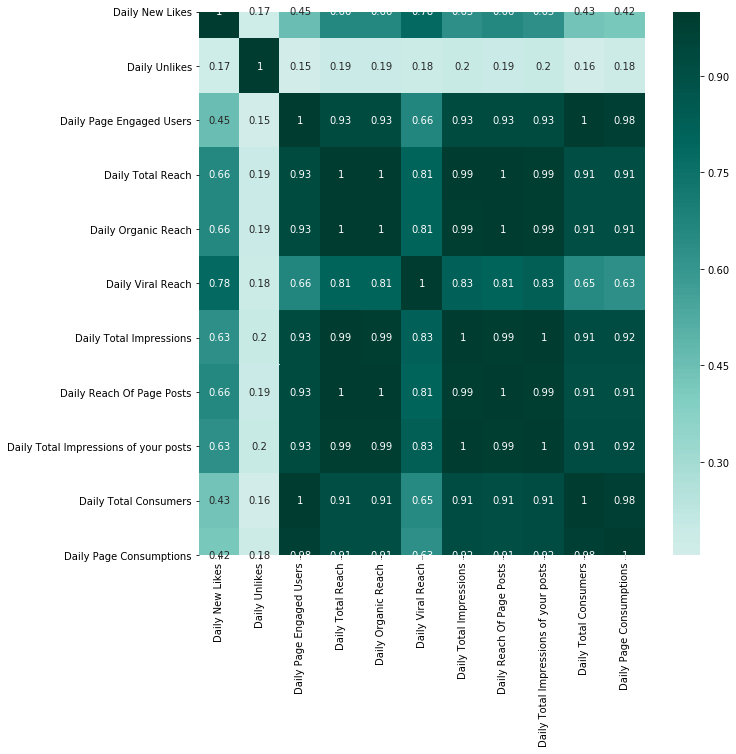

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_page_r.corr(), center=0, cmap='BrBG', annot=True)

The result is quite clear for the first question:

#### "What are the factors that influence new daily page like?"
1. Daily Viral Reach
2. Daily Reach of Page Posts, Total Reach, Organic Reach (or we can conclude as 'Total Reach' which is superset for all of them)
3. Daily Total Impressions, Total Impressions of posts (or we can conclude as 'Impressions' which is superset for all of them)

Since this is page level data, I want to join them with post level data to see the relationship and how correlate of the metrics at post level with page level. Expecially, the relationship of from post level with these 3 metrics.

So, I start with joining both data using page level date and post level's post date as key to join data and convert data type to number as necessary.

In [22]:
# convert data type of post level's  and page level
df_page_r_date['Date'] = pd.to_datetime(df_page_r_date['Date'])
df['Posted Date'] = [pd.to_datetime(d.date()) for d in df['Posted']]

# bing only necessary data from page level. I don't include Daily Reach of Page Posts and Total Impression because it is already part of the post level data
df_page_like = df_page_r_date[['Date','Lifetime Total Likes', 'Daily New Likes', 'Daily Viral Reach']]
df_merge = pd.merge(df,df_page_like, left_on='Posted Date', right_on='Date', how='left')

# since page level has only the data for last 6 months while post level has 2 years, I drop all of the post level data that doesn't has page level data.
df_merge.dropna(subset=['Lifetime Total Likes'],inplace=True)

# convert data to make it ready for correlation calculation
df_merge['Lifetime Total Likes'] = pd.to_numeric(df_merge['Lifetime Total Likes'])
df_merge['Daily New Likes'] = pd.to_numeric(df_merge['Daily New Likes'])
df_merge['Daily Viral Reach'] = pd.to_numeric(df_merge['Daily Viral Reach'])
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 29 to 42
Data columns (total 56 columns):
Audience Targeting                                                             14 non-null object
Lifetime Average time video viewed                                             14 non-null object
Total Engaged Users                                                            14 non-null int64
Lifetime Matched Audience Targeting Consumers on Post                          14 non-null object
Lifetime Matched Audience Targeting Consumptions by Type - link clicks         10 non-null float64
Lifetime Matched Audience Targeting Consumptions by Type - other clicks        14 non-null object
Lifetime Matched Audience Targeting Consumptions by Type - photo view          14 non-null float64
Lifetime Matched Audience Targeting Consumptions on Post                       14 non-null object
Lifetime Negative Feedback                                                     14 non-null object
Lifetime Nega

Unfortunately, the data point is reduced to be only 14. It's time to see the result. I'll use DataFrame's corr() function to see co-efficient and visualize with Seaborn heatmap.

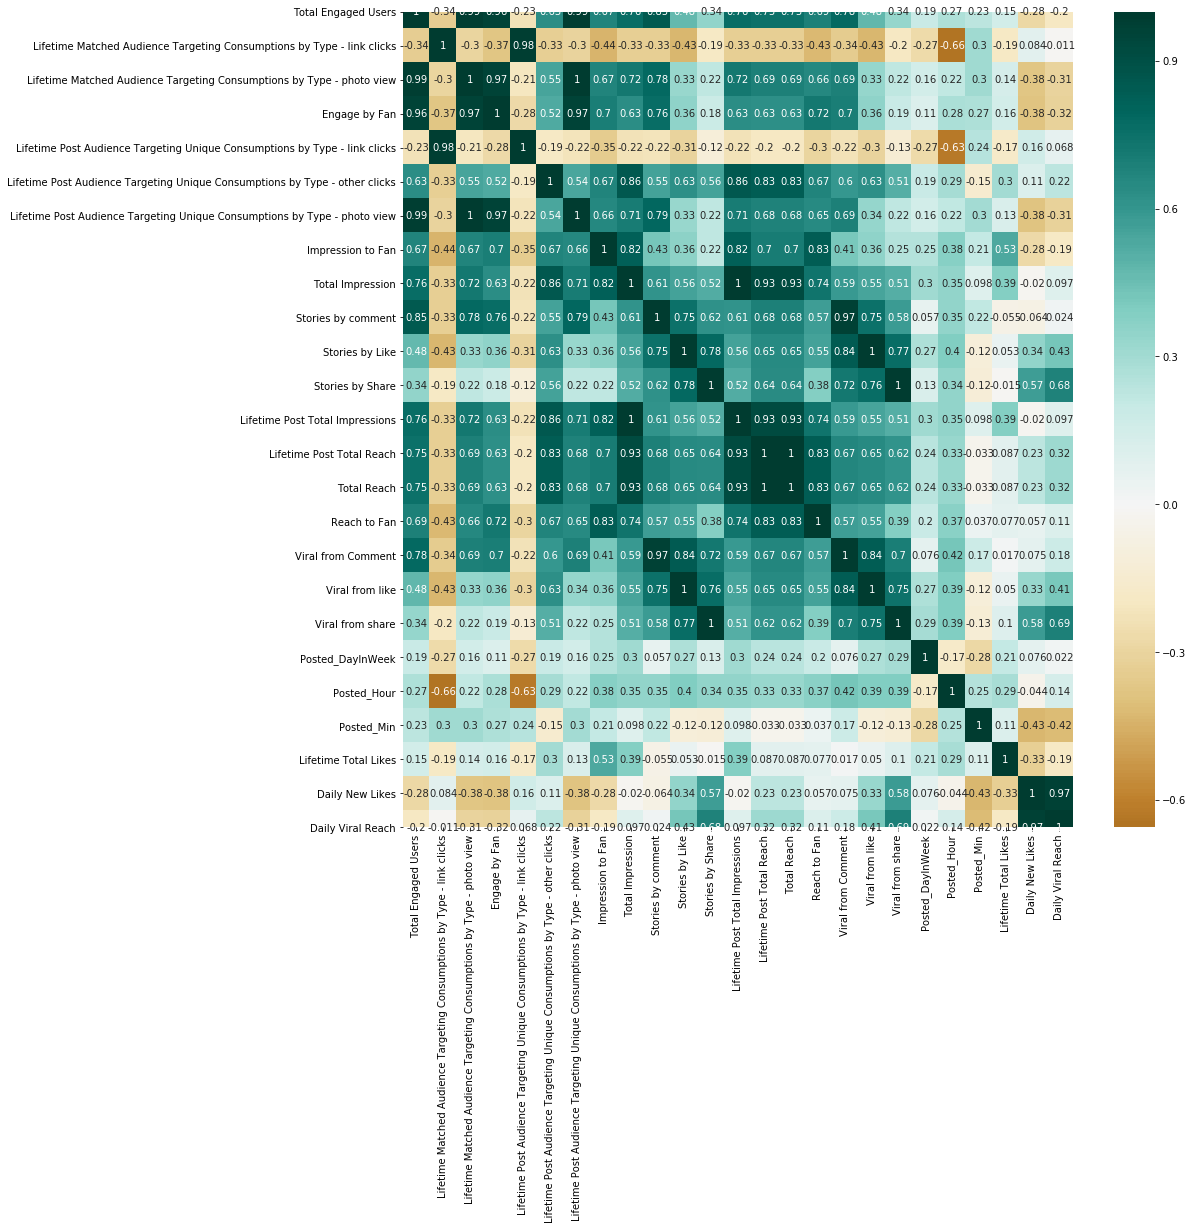

In [24]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_merge.corr(), center=0, cmap='BrBG', annot=True)

From the result, we can get the extended answer of the first question as:

1. Daily Viral Reach is correlated the most with 
    - "stories by Share" and "stories by Like" (number of the post's share and like)
2. Total Reach is correlated the most with
    - "Total Impression"
    - "Any click on the post (exclude photos and link e.g. expand comment etc.)"
3. Total Impression is correlated the most with
    - "Total Reach"
    - "Impression to Fan"
    - "Any click on the post (exclude photos and link e.g. expand comment etc.)"

#### "What are the factors that influence new daily page like?"

In summary, increment of the page's "Daily Viral Reach" is the most correlated with increment of "Daily Page Like".
To increase "Daily Viral Reach" at Post level, we should influence the user to do "Share or Like" and "Click at any places in the post e.g. comment, link, view photo, expand comment section etc. (rather than just slide, stop and slide to next content)". Ideally, the page admin should also boost the post to increase "Total Reach" which will also influence Daily Viral Reach.

Next, I'll work on visualizing the trend of the factors that effect "Daily Page Like" which are "Stories by Share", "Stories by Like" and "Any clik on the post"

In [29]:
df1 = df[['Posted Date','Stories by Like', 'Stories by Share', 'Lifetime Post Audience Targeting Unique Consumptions by Type - other clicks', 'Total Impression', 'Total Reach']]
df1.describe()

,Stories by Like,Stories by Share,Lifetime Post Audience Targeting Unique Consumptions by Type - other clicks,Total Impression,Total Reach
count,100.000000,96.000000,97.000000,100.000000,100.000000
mean,474.580000,24.843750,1116.113402,20265.790000,13983.360000
std,340.829593,30.645109,840.710487,13982.388482,9283.105653
min,38.000000,1.000000,77.000000,0.000000,0.000000
25%,249.000000,7.000000,488.000000,11547.000000,8250.750000
50%,413.500000,13.000000,977.000000,17386.000000,12081.500000
75%,596.250000,33.000000,1565.000000,24867.500000,18009.750000
max,2349.000000,165.000000,4469.000000,81268.000000,55269.000000


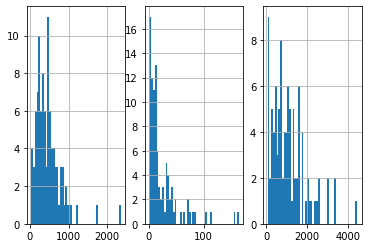

In [71]:
f, axes = plt.subplots(1, 3)
df1['Stories by Like'].hist(bins=50, ax=axes[0])
df1['Stories by Share'].hist(bins=50, ax=axes[1])
df1['Lifetime Post Audience Targeting Unique Consumptions by Type - other clicks'].hist(bins=50, ax=axes[2])

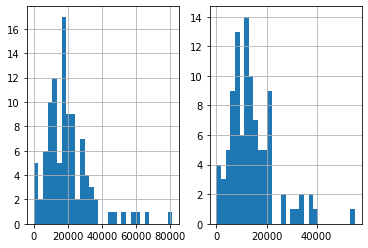

In [72]:
f, axes = plt.subplots(1, 2)
df1['Total Impression'].hist(bins=30, ax=axes[0])
df1['Total Reach'].hist(bins=30, ax=axes[1])

From the descriptive statistic and histogram of these factors, we can briefly conclude the answer of the question:

### Given there is a new post published on my page, what are the approximate value of each factors that influences the page like?
1. Like : 0 - 1,100
2. Share : 0 - 85
3. Post Click : 0 - 2,700
4. Impression : 0 - 48,000
5. Reach : 0 - 32,000


Next is the last question : 
#### How can we predict daily page like when there is a new post published?

To answer, I'll try to build predictive model with linear regression.
The ideal dataset should be the "df_merge" which has post level data and page level data.
However, the datapoint is very low at 14 due to data limitation.

So, I decide to predict the factor that has the highest correlation with new page like which is "Share" instead.

I have tried with different set of independant variables and found that this set yield the best result based on r-square.

In [101]:
X = df[['Total Impression', 'Stories by Like']]
y = df['Stories by Share']

X=X.fillna(0)
y=y.fillna(0)

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model was 0.8523800815849778 on 30 values.'

By using this model, I can predict the baseline of my post share with error around 15%.

In [102]:
data = {'Total Impression':[11500],
        'Stories by Like':[250]
       }
X_test2 = pd.DataFrame(data)
y_test2 = lm_model.predict(X_test2)
y_test2

array([6.27235918])

In [106]:
data = {'Total Impression':[11000],
        'Stories by Like':[533]
       }
X_test2 = pd.DataFrame(data)
y_test2 = lm_model.predict(X_test2)
y_test2

array([19.30277386])

I also tries with page level data to predice Daily New Likes directly and seems like linear regression is not a good model for this data set as r-square is lower than 80%.

In [109]:
X = df_page_r[['Daily Page Engaged Users', 'Daily Viral Reach', 'Daily Total Impressions of your posts', 'Daily Total Reach', 'Daily Organic Reach', 'Daily Total Impressions', 'Daily Reach Of Page Posts']]
y = df_page_r['Daily New Likes']

X=X.fillna(0)
y=y.fillna(0)

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for your model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for your model was 0.764623628878949 on 44 values.'

## Summary

#### 1. "What are the factors that influence new daily page like?"
- Increment of the page's "Daily Viral Reach" is the most correlated with "Daily Page Like". 
- To increase "Daily Viral Reach" at Post level, we should influence the user to do "Share or Like" and "Click at any places in the post e.g. comment, link, view photo, expand comment section etc. (rather than just slide, stop and slide to next content)". 
- Ideally, the page admin should also boost the post to increase "Total Reach" which will also influence Daily Viral Reach.

##### Factors that doesn't influence that much
- Total Page Like : It has some correlation with post impression only.
- The post's Day of week : But post hour does has some influence even it is not high (30%).

#### 2. "What are the expected value of the factors that influence new daily page like?"
Like       : starting from 38 with 50% chance to be around 250-600 and not likely to over than 1,100 

Share      : starting from 1 with 50% chance to be around 7-33 and not likely to over than 84

Total Impression : starting from 0 with 50% chance to be around 11,500-24,900 and not likely to over than 48,000

Total Reach      : starting from 0 with 50% chance to be around 8,250-18,000 and not likely to over than 32,000

#### 3. "How can we predict new page like?"
- We can't predict directly now due to low datapoint of page & post combined.
- However, we can predict "Share" from "Like" and "Impression" using linear regression with 85% R-Square.
- Linear regression can't be used to predict Daily New Like at page level data as the best R-Square is lower than 80%. Other predictive model should be considered.